In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

import datasets
from tqdm.notebook import tqdm

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding
)

2022-11-26 13:32:00.295549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-26 13:32:00.442146: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-26 13:32:01.057489: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/modaresi/.conda/envs/globenc-venv/lib/
2022-11-26 13:32:01.057619: W tensorflow/

In [3]:
MODEL_PATH =  "/home/modaresi/projects/globenc_analysis/outputs/models/output_mnli_bert-base-uncased_0001_SEED0042/checkpoint-61360"

TASK = "mnli"
 
SET = "validation_matched"  # train/validation/validation_matched

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [4]:
GLUE_TASKS = ["cola", "mnli", "mnli-mm", "mrpc", "qnli", "qqp", "rte", "sst2", "stsb", "wnli"]

BATCH_SIZE = 24
MAX_LENGTH = 128

actual_task = "mnli" if TASK == "mnli-mm" else TASK
dataset = datasets.load_dataset("glue", actual_task)
metric = datasets.load_metric('glue', actual_task)
task_to_keys = {
    "cola": ("sentence", None),
    "mnli": ("premise", "hypothesis"),
    "mnli-mm": ("premise", "hypothesis"),
    "mrpc": ("sentence1", "sentence2"),
    "qnli": ("question", "sentence"),
    "qqp": ("question1", "question2"),
    "rte": ("sentence1", "sentence2"),
    "sst2": ("sentence", None),
    "stsb": ("sentence1", "sentence2"),
    "wnli": ("sentence1", "sentence2"),
}
SENTENCE1_KEY, SENTENCE2_KEY = task_to_keys[TASK]
dataset

Reusing dataset glue (/opt/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [5]:
def preprocess_function_wrapped(tokenizer):
    def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[SENTENCE1_KEY],) if SENTENCE2_KEY is None else (examples[SENTENCE1_KEY], examples[SENTENCE2_KEY])
        )
        result = tokenizer(*args, padding=False, max_length=MAX_LENGTH, truncation=True)
        return result
    return preprocess_function

def token_id_to_tokens_mapper(tokenizer, sample):
    length = len(sample["input_ids"])
    return tokenizer.convert_ids_to_tokens(sample["input_ids"])[:length], length

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
model.to(torch.device("cuda:0"))
model.eval()

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, use_fast=True, max_length=MAX_LENGTH)

sel_dataset = dataset[SET].map(preprocess_function_wrapped(tokenizer), batched=True, batch_size=1024)
dataset_size = len(sel_dataset)
print(dataset_size)

Parameter 'function'=<function preprocess_function_wrapped.<locals>.preprocess_function at 0x7f19a6623ef0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/10 [00:00<?, ?ba/s]

9815


In [10]:
saliencies = np.load("/home/modaresi/projects/globenc_analysis/outputs/saliencies/mnli_bert-base-uncased_0001_SEED0042_checkpoint-61360.npy") * np.load("/home/modaresi/projects/globenc_analysis/outputs/saliencies_angle/mnli_bert-base-uncased_0001_SEED0042_checkpoint-61360.npy")
saliencies.shape

(9815, 128)

In [11]:
results = []
for i in tqdm(range(11)):
    def mapping_masks(example):
        length = np.sum(example["attention_mask"])
        sal_rank = saliencies[example["idx"]][:length].argsort()
        sal_rank = sal_rank[~np.in1d(sal_rank, np.argwhere(np.array(example["input_ids"]) < 103).flatten())]
        mask_count = int(np.floor(len(sal_rank) * i / 10.0))
        masks = sal_rank[:mask_count]
        example["input_ids"] = [tokenizer.mask_token_id if j in masks else example["input_ids"][j] for j in range(length)]
        return example
    modified_set = sel_dataset.map(mapping_masks)
    modified_set.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
    collator = DataCollatorWithPadding(tokenizer, True, MAX_LENGTH, return_tensors="pt")
    dataloader = torch.utils.data.DataLoader(modified_set, batch_size=BATCH_SIZE, collate_fn=collator)
    steps = int(np.ceil(dataset_size / BATCH_SIZE))
    num_labels = len(set(modified_set['label']))

    it = iter(dataloader)
    y_preds = torch.zeros(size=(dataset_size,)).cuda()
    y_trues = torch.zeros(size=(dataset_size,), dtype=torch.int32).cuda()

    with torch.no_grad():
        for i in tqdm(range(steps)):
            batch = next(it)
            batch = {k: v.to(torch.device('cuda:0')) for k, v in batch.items()}
            inputs = {
                'input_ids': batch['input_ids'],
                'attention_mask': batch['attention_mask'],
                'token_type_ids': batch['token_type_ids'],
            }
            y_trues[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = batch['labels']
            output = model(**batch)
            y_preds[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = torch.argmax(output.logits, dim=-1)
    
    results.append(np.mean((y_trues == y_preds).cpu().numpy()))
    print(results[-1])

  0%|          | 0/11 [00:00<?, ?it/s]

0ex [00:00, ?ex/s]

  0%|          | 0/409 [00:00<?, ?it/s]

0.8421803362200713


0ex [00:00, ?ex/s]

  0%|          | 0/409 [00:00<?, ?it/s]

0.7201222618441161


0ex [00:00, ?ex/s]

  0%|          | 0/409 [00:00<?, ?it/s]

0.6619460010188487


0ex [00:00, ?ex/s]

KeyboardInterrupt: 

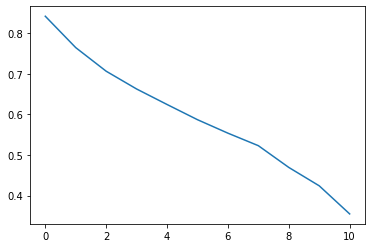

In [9]:
import matplotlib.pyplot as plt

plt.plot(results)

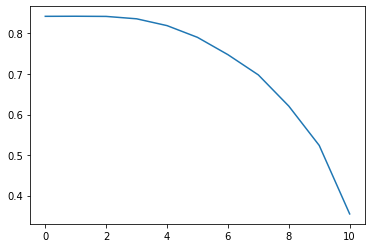

In [42]:
import matplotlib.pyplot as plt

plt.plot(results)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    "bert-base-uncased",
    use_fast=True,
)

def _get_preprocessing_function(
    sentence1_key: str, 
    sentence2_key: str = None, 
    label_to_id: dict = None):

    def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
        )
        result = tokenizer(*args, padding=False, max_length=MAX_LENGTH, truncation=True)

        # Map labels to IDs (not necessary for GLUE tasks)
        if label_to_id is not None and "label" in examples:
            result["label"] = [(label_to_id[l] if l != -1 else -1) for l in examples["label"]]
        return result
    
    return preprocess_function

# preprocess_function = _get_preprocessing_function(sentence1_key="premise", sentence2_key="hypothesis")
preprocess_function = _get_preprocessing_function(sentence1_key="sentence")
train_ds = original_ds.map(preprocess_function, batched=True)